# $$ \text{Imágenes Satelitales} \cap \text{Python} $$

## Datos: [Imagen Landsat8](https://drive.google.com/drive/folders/1oXZJR4rHiAJO4yJnyx8xuAw1XgfOrOmd). 

Primero descargar y descomprimir, y luego ubicarla en la ruta `r'./notebook/data/IMG_01'`

- #### Recursos:
    - Puedes descargar otras imagenes en [Earth Explorer](https://earthexplorer.usgs.gov/) (las imagenes **Level 2** tardan **24Hrs** luego de solicitarla). 

- #### Manuales:

    - Es importante **Leer el Manual** de la imagen con la que uno va a trabajar, ya que suele aportar informacion acerca del contenido de los datos y también nos avisa si es necesario, por ejemplo, multiplicar los datos por alguna constante para que representen la magnitud fisica de interes.
    - En nuestro caso, las **Landsat8** hay que multiplicarlas por un factor de **0.0001** y así cada pixel estara representando la reflectancia en superficie.
    - #### Descargar:
        - [Manual -- Repositorio](/L8Handbook/lasrc_product_guide.pdf)
        - [Manual -- Online](https://landsat.usgs.gov/sites/default/files/documents/Landsat8DataUsersHandbook.pdf)

## 0. Importamos las librerías

In [ ]:
#utilizar nbagg o notebook, para poder interactuar con los gráficos.
#%matplotlib notebook
#%matplotlib nbagg 

In [1]:
#funciones y clases particulares al caso de estudio
from localpacks.function import firmas_teo, array2raster_1band, array2raster

#data sets
import numpy as np
import pandas as pd

#detectar patones regulares en las rutas de los directorios
import glob 

#para crear un STACK y un CLIP
import gdal 

#definir POLIGONOS
from roipoly import roipoly

#para hacer una CLASIFICACION de la imagen
from skimage import exposure

#graficos
import seaborn as sns
import matplotlib.pyplot as plt

## Firmas Teo

Si medimos el indice de reflectancia para cada banda espectral, podemos observar que cada terreno tiene un comportamiento diferente y específico, es en otras palabras, como una especie de huella digital para cada tipo de terreno.

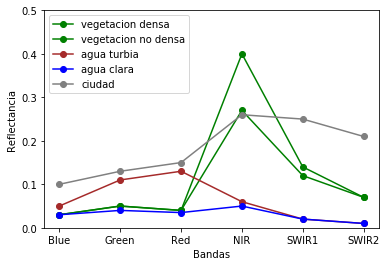

In [2]:
firmas_teo() #huella espectral para cada tipo de terreno

## 1. Importamos las bandas, creamos un stack y clipeamos la imagen:

### 1.1 Levantamos las bandas y hacemos el stack:

In [3]:
src = r'./data/L8_225084' #seleccionamos el directorio de trabajo
tifs = glob.glob(src+'/*_sr_band?.tif') # con la expresion regular elegimos todas las imagenes _sr_band.tif 
tifs.sort() # es importante ordenar las bandas
tifs

['./data/L8_225084\\LC08_L1TP_225084_20180213_20180222_01_T1_sr_band1.tif',
 './data/L8_225084\\LC08_L1TP_225084_20180213_20180222_01_T1_sr_band2.tif',
 './data/L8_225084\\LC08_L1TP_225084_20180213_20180222_01_T1_sr_band3.tif',
 './data/L8_225084\\LC08_L1TP_225084_20180213_20180222_01_T1_sr_band4.tif',
 './data/L8_225084\\LC08_L1TP_225084_20180213_20180222_01_T1_sr_band5.tif',
 './data/L8_225084\\LC08_L1TP_225084_20180213_20180222_01_T1_sr_band6.tif',
 './data/L8_225084\\LC08_L1TP_225084_20180213_20180222_01_T1_sr_band7.tif']

Almacenamos en `tifs` todas las imagenes _sr_band.tif

In [4]:
l8_stack_vrt_name =src+'l8_stack_vrt.vrt'
l8_stack_vrt = gdal.BuildVRT(l8_stack_vrt_name, tifs, separate=True)

'''This program builds a VRT (Virtual Dataset) that is a mosaic of the list of input GDAL datasets.

The list of input GDAL datasets can be specified at the end of the command line, or put in a text file (one filename per line) for very long lists,
or it can be a MapServer tileindex (see gdaltindex utility).

In the later case, all entries in the tile index will be added to the VRT.With -separate, each files goes into a separate band in the VRT band. 
Otherwise, the files are considered as tiles of a larger mosaic and the VRT file has as many bands as one of the input files.
'''

l8_stack_tif_name = src+'l8_stack.tif'
l8_stack = gdal.Translate(l8_stack_tif_name,l8_stack_vrt)


'''
The gdal_translate utility can be used to convert raster data between different formats, potentially performing some operations like:
subsettings, resampling, and rescaling pixels in the process. 
'''

#imprimimos el formato de nuestro stack
'Formato: %s - %s bandas, (%s filas, %s columnas)' % (l8_stack.GetDriver().LongName, l8_stack.RasterCount, l8_stack.RasterYSize, l8_stack.RasterXSize )

'Formato: GeoTIFF - 7 bandas, (7731 filas, 7681 columnas)'

In [5]:
#img_geotransform = l8_stack.GetGeoTransform()
#print("La esquina arriba a la izquierda, tiene coordenadas:")
#print("La resolución de los pxeles es: ")

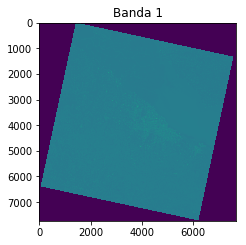

In [6]:
plt.figure(figsize=(12,4))

#RECORDAMOS QUE TENEMOS 7 BANDAS
b1 = l8_stack.ReadAsArray()[1,:,:]
#b2 = l8_stack.ReadAsArray()[2,:,:]
#b3 = l8_stack.ReadAsArray()[3,:,:]

plt.subplot(131)
plt.title('Banda 1')
plt.imshow(b1)

#plt.subplot(132)
#plt.title('Banda 1')
#plt.imshow(b2)

#plt.subplot(133)
#plt.title('Banda 3')
#plt.imshow(b3);

#plt.savefig(src+'b3.jpg')

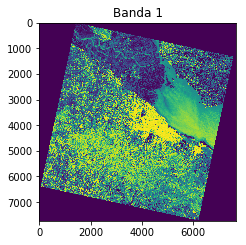

In [7]:
plt.figure(figsize=(12,4))

#RECORDAMOS QUE TENEMOS 7 BANDAS
b1_equa = exposure.equalize_hist(b1)
#b2_equa = exposure.equalize_hist(b2)
#b3_equa = exposure.equalize_hist(b3)

plt.subplot(131)
plt.title('Banda 1')
plt.imshow(b1_equa);

#plt.subplot(132)
#plt.title('Banda 1')
#plt.imshow(b2_equa)

#plt.subplot(133)
#plt.title('Banda 3')
#plt.imshow(b1_equa);

#plt.savefig(src+'b3_equa.jpg')

### 1.3 Pasamos a coordenadas geograficas:

In [8]:
l8_latlong_name = src+'l8_latlong.tif'
l8_latlong = gdal.Warp(l8_latlong_name,l8_stack,dstSRS='EPSG:4326')

#The gdalwarp utility is an image mosaicing, reprojection and warping utility.

# dstSRS -> output SRS (Spatial reference system)

In [9]:
del l8_stack #ya no la usamos mas

### 1.4 Realizamos un clip:


In [10]:
#bajo Delta:
xmin=-58.6
xmax=-58.4
ymin=-34.5
ymax=-34.29

l8_clip_name = src+'l8_clip.tif'
l8_clip = gdal.Warp(l8_clip_name,l8_latlong,outputBounds= (xmin,ymin,xmax,ymax))

In [11]:
del l8_latlong # ya no la usamos mas, ns quedamos con el clip

### Multiplicamos por 0.0001


In [12]:
l8_clip_array = 0.0001*l8_clip.ReadAsArray()

### 1.5 Obervamos el clip en RGB:

C:\Users\USUARIO\Anaconda3\envs\img_sat\lib\site-packages\skimage\exposure\exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


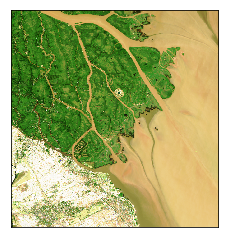

In [13]:

#Stack arrays in sequence depth wise (along third axis).
img_r = l8_clip_array[3,:,:]
img_g = l8_clip_array[2,:,:]
img_b = l8_clip_array[1,:,:]

img_rgb = np.dstack([img_r,img_g,img_b])

img_rgb = exposure.equalize_hist(img_rgb)

plt.imshow(img_rgb)

plt.xticks([])
plt.yticks([]);

#plt.savefig(src+'img_rgb.jpg')


In [14]:
array2raster(src+'img_rgb.tif', img_rgb, l8_clip.GetGeoTransform(), l8_clip.GetProjection())

## 2. Extracción de polígonos con roipoly

#### Creacion de poligonos

Para esto utlizaremos la clase "roipoly", veamos como crear un poligono:

TypeError: 'module' object is not callable

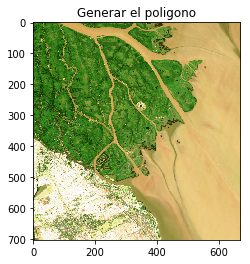

In [15]:
from roipoly import roipoly

plt.imshow(img_rgb)
plt.title('Generar el poligono')
pol1 = roipoly(roicolor='r')



#### Obtención de máscaras:
Podemos hallar la mascara generada por el polígono:
(¿Qué es una máscara?)


In [ ]:
mask_pol1 = pol1.getMask(img_rgb[:,:,0])
mask_pol1
print(mask_pol1.shape)

In [ ]:

plt.imshow(mask_pol1)

##### Ahora, utilizando la máscara, obtener los valores de los pixeles que pertenecen al polígono:

In [ ]:
valores_poli1_mask = l8_clip_array[:,mask_pol1]
valores_poli1_mask.shape

In [ ]:
#df = pd.DataFrame(valores_poli1_mask.T,columns=['Banda1','Banda2','Banda3','Banda4','Banda5','Banda6','Banda7']).head()
#df['clase']='vegetacion'
#df

##### Cómo podemos hacer para observar algun polígono ya marcado y crear uno nuevo?

Ahora mostramos el polígono marcado y creamos uno nuevo:

In [ ]:
# Ploteamos la img:
plt.imshow(img_rgb)
# Ploteamos los poligonos calculando anteriormente:
[x.displayROI() for x in [pol1]]
# Armamos un nuevo poligono
pol2 = roipoly(roicolor='b')

#### Misión:
    1) En la imagen se pueden observar distintas regiones homogeneas. Marcar 3 polígonos distintos en la imagen rgb, cada uno de ellos correspondiente a una zona homogenea distinta. Llamar a los polígonos: pol1, pol2 y pol3
    2) Luego, extraer los valores (en todas las bandas) de los pixeles asociados a cada polígono. Llamar a cada conjunto de datos: valores_pol1, valores_pol2 y valores_pol3.

In [ ]:

plt.imshow(img_rgb)
pol_1 = roipoly(roicolor='r') 

In [ ]:
plt.imshow(img_rgb)
[x.displayROI() for x in [pol_1]]

pol_2 = roipoly(roicolor='b')

In [ ]:
plt.imshow(img_rgb)
[x.displayROI() for x in [pol_1,pol_2]]

pol_3 = roipoly(roicolor='g')

In [ ]:
plt.imshow(img_rgb)
[x.displayROI() for x in [pol_1,pol_2,pol_3]]
plt.title('Img RGB + poligonos')

In [ ]:

poli_1_mask = pol_1.getMask(img_r)
poli_2_mask = pol_2.getMask(img_r)
poli_3_mask = pol_3.getMask(img_r)


valores_poli_1_mask = l8_clip_array[:,poli_1_mask]
valores_poli_2_mask = l8_clip_array[:,poli_2_mask]
valores_poli_3_mask = l8_clip_array[:,poli_3_mask]

plt.imshow(poli_1_mask+4*poli_2_mask+8*poli_3_mask)

In [ ]:
mask = poli_1_mask+4*poli_2_mask+8*poli_3_mask
array2raster_1band(src+'mask.tif', mask, l8_clip.GetGeoTransform(), l8_clip.GetProjection())

#### 2.1 Comparando las firmas espectrales, asociamos a cada polígono con un tipo de cobertura

Graficar las firmas espectrales asociadas a cada polígono

In [ ]:
values = [valores_poli_1_mask,valores_poli_2_mask,valores_poli_3_mask]
x = [0,1,2,3,4,5,6]

#plt.xkcd()
for i in range(2,3):
    valor = values[i]
    plt.errorbar(x,np.mean(valor,axis=1),yerr=np.std(valores_poli_1_mask,axis=1))
    plt.plot(x,np.mean(valor,axis=1))

firmas_teo()

## Concluir cada polígono a que cobertura pertenece, cambiar los nombres:

In [ ]:
valores_vegetacion = valores_poli_1_mask
valores_agua = valores_poli_2_mask
valores_ciudad = valores_poli_3_mask

#Para utilizar clases no pesadas (es decir, la misma cantidad de datos de entrenamiento de cada clase):

#min_val = np.min([valores_vegetacion.shape[1], valores_agua.shape[1],valores_ciudad.shape[1]])
# En este caso elegi los primeros min_val pixeles de cada clase pero utilizando np.random.choice(,replace=False) podriamos aleatorizar la 
# eleccion. Beneficio: si bien los pixeles estan dentro del mismo poligono difumino un poco la relacion espacial y obtengo una muestra con un poquito de variabilidad.

#valores_agua = valores_agua[:,0:min_val]
#valores_vegetacion = valores_vegetacion[:,0:min_val]
#valores_ciudad = valores_ciudad[:,0:min_val]

## 3. Crear un mapa de coberturas

### ¿Cómo podemos automatizar la clasificación en vez de ir analizando cada pixel por separado?

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split

x_data = np.concatenate((valores_agua.T,valores_vegetacion.T, valores_ciudad.T))

x_class = 4*np.concatenate((np.ones(valores_agua.shape[1]),2*np.ones(valores_vegetacion.shape[1]),3*np.ones(valores_ciudad.shape[1])))

x_train, x_test, y_train, y_test = train_test_split(x_data, x_class, test_size=0.3, random_state=4)

In [ ]:

clf = KNN(n_neighbors=20,metric='euclidean')
clf.fit(x_train,y_train)

In [ ]:
bands, rows, cols = l8_clip_array.shape

n_samples = rows*cols
flat_pixels = l8_clip_array.reshape((bands, n_samples))

result = clf.predict(flat_pixels.T)
classification = result.reshape((rows, cols))
np.unique(classification)

In [ ]:
plt.imshow(classification)

In [ ]:
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(classification)
plt.xticks([])
plt.yticks([])

Evaluacion

In [ ]:
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix

y_pred = clf.predict(x_test)

print(accuracy_score(y_test, y_pred, normalize=True))
confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.clf()
plt.imshow(cm,interpolation='nearest',cmap='Pastel1')#cmap='PiYG')
for i in range(3):
    for j in range(3):
        plt.text(i,j,str(cm[i][j]))
plt.show()

classNames = ['agua','vegetacion','ciudad']
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)

In [ ]:
print(valores_agua.shape[1])
print(valores_vegetacion.shape[1])
print(valores_ciudad.shape[1])

### Y luego de tanto trabajo, no olvidemos guardar nuestro exitoso resultado!

In [ ]:
#array2raster(out_name, array, geo_trans, proj)

out_name= src+'clasificacion.tif'
array= classification
geo_trans= l8_clip.GetGeoTransform()
proj= l8_clip.GetProjection()

array2raster_1band(out_name, array, geo_trans, proj)

In [ ]:
test = gdal.Open(out_name)

plt.imshow(test.ReadAsArray()==4)